In [15]:
using Pkg
#Pkg.add("FileIO")
#Pkg.add("Colors")
#Pkg.add("GPUArrays")
#Pkg.add("BenchmarkTools")
#Pkg.add("ImageShow")
#Pkg.add("ImageMagick")

 Resolving package versions...
 Installed ImageMagick ─ v0.7.5
  Updating `~/.julia/environments/v1.2/Project.toml`
  [6218d12a] + ImageMagick v0.7.5
  Updating `~/.julia/environments/v1.2/Manifest.toml`
  [6218d12a] + ImageMagick v0.7.5
  Building ImageMagick → `~/.julia/packages/ImageMagick/vMfoS/deps/build.log`


In [1]:
using CUDAdrv; CUDAdrv.name(CuDevice(0))

"GeForce GTX 1060"

In [3]:
using CuArrays, FileIO, Colors, GPUArrays, BenchmarkTools, ImageShow
using CuArrays: CuArray

In [4]:
#The function calculating the Julia set
function juliaset(z0, maxiter)
    c = ComplexF32(-0.5, 0.75)
    z = z0
    for i in 1:maxiter
        abs2(z) > 4f0 && return (i - 1) % UInt8
        z = z * z + c
    end
    return maxiter % UInt8 # % is used to convert without overflow check
end

range = 100:50:2^12
cutimes, jltimes = Float64[], Float64[]

function run_bench(in, out)
  # use dot syntax to apply `juliaset` to each elemt of q_converted 
  # and write the output to result
  out .= juliaset.(in, 16)
  # all calls to the GPU are scheduled asynchronous, 
  # so we need to synchronize
  GPUArrays.synchronize(out)
end

run_bench (generic function with 1 method)

In [5]:
# store a reference to the last results for plotting
last_jl, last_cu = nothing, nothing
for N in range
  w, h = N, N
  q = [ComplexF32(r, i) for i=1:-(2.0/w):-1, r=-1.5:(3.0/h):1.5]
  for (times, Typ) in ((cutimes, CuArray), (jltimes, Array))
    # convert to Array or CuArray - moving the calculation to CPU/GPU
    q_converted = Typ(q)
    result = Typ(zeros(UInt8, size(q)))
    for i in 1:10 # 5 samples per size
      # benchmarking macro, all variables need to be prefixed with $
      t = Base.@elapsed begin
        run_bench(q_converted, result)
      end
      global last_jl, last_cu # we're in local scope
      if result isa CuArray
        last_cu = result
      else
        last_jl = result
      end
        push!(times, t)
    end
  end
end

┌ Info: Precompiling ImageMagick [6218d12a-5da1-5696-b52f-db25d2ecc6d1]
└ @ Base loading.jl:1242


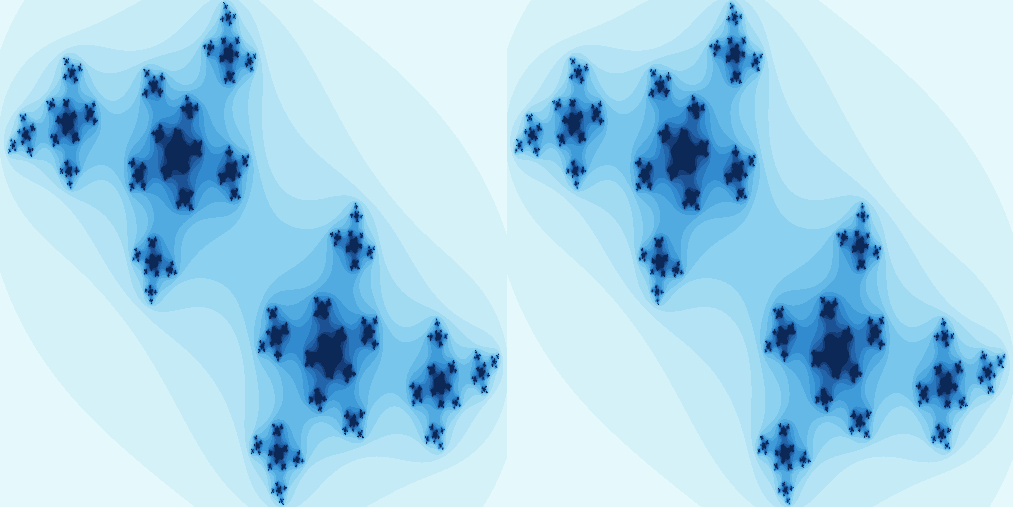

In [16]:
cu_jl = hcat(Array(last_cu), last_jl)
cmap = colormap("Blues", 16 + 1)
color_lookup(val, cmap) = cmap[val + 1]
color_lookup.(cu_jl, (cmap,))